In [1]:
%pylab inline
import pandas as pd
from pandas import Series, DataFrame
import re
import datetime as dt
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20, 10))

Populating the interactive namespace from numpy and matplotlib


### Data Cleaning

In [319]:
dfTrain = pd.read_csv('train.csv', header=0)
dfTrain.drop(['Ticket','Cabin','Embarked'], axis=1, inplace=True)

In [320]:
# fill missing age throught interpolation
dfTrain['Gender'] = dfTrain['Sex'].map( {'female': 0, 'male': 1} )
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = dfTrain[(dfTrain['Gender'] == i) & (dfTrain['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

array([[35. , 28. , 21.5],
       [40. , 30. , 25. ]])

In [321]:
dfTrain['AgeFill'] = dfTrain['Age']

In [322]:
for i in range(0, 2):
    for j in range(0, 3):
        dfTrain.loc[ (dfTrain.Age.isnull()) & (dfTrain.Gender == i) & (dfTrain.Pclass == j+1),'AgeFill'] = median_ages[i,j]

In [323]:
print(dfTrain['Age'].isnull().sum())
print(dfTrain['AgeFill'].isnull().sum())

177
0


In [324]:
dfTrain.drop(['Age'], axis=1, inplace=True)

### EDA

In [325]:
print(dfTrain.shape)
dfTrain.head()

(891, 10)


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Fare,Gender,AgeFill
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,7.2500,1,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,71.2833,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,7.9250,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,53.1000,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,8.0500,1,35.0


In [326]:
display(dfTrain.describe())

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.523008,0.381594,32.204208,0.647587,29.112424
std,257.353842,0.486592,0.836071,1.102743,0.806057,49.693429,0.477990,13.304424
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,0.000000,0.000000,7.910400,0.000000,21.500000
50%,446.000000,0.000000,3.000000,0.000000,0.000000,14.454200,1.000000,26.000000
75%,668.500000,1.000000,3.000000,1.000000,0.000000,31.000000,1.000000,36.000000
max,891.000000,1.000000,3.000000,8.000000,6.000000,512.329200,1.000000,80.000000


### Train Test Split

In [327]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split

In [328]:
from sklearn import metrics

In [329]:
formula = 'Survived ~ C(Pclass) + C(Sex) + AgeFill + SibSp' 
y, x = dmatrices(formula, data=dfTrain, return_type='dataframe')

In [330]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

### Decision Tree
reference:

    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [331]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

without pruning

In [332]:
estimator = DecisionTreeClassifier(criterion='gini')
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.7912311265969801


score is mean accuracy, we can see that train accuracy keep decreasing and test accuracy keep increasing

this indicates that the classifier is overfitting to training data. as the data size grows, training accuracy decrease

Meanwhile test accracy increase, which showns the classifier is indeed learning to generalize to unseen data

In [333]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

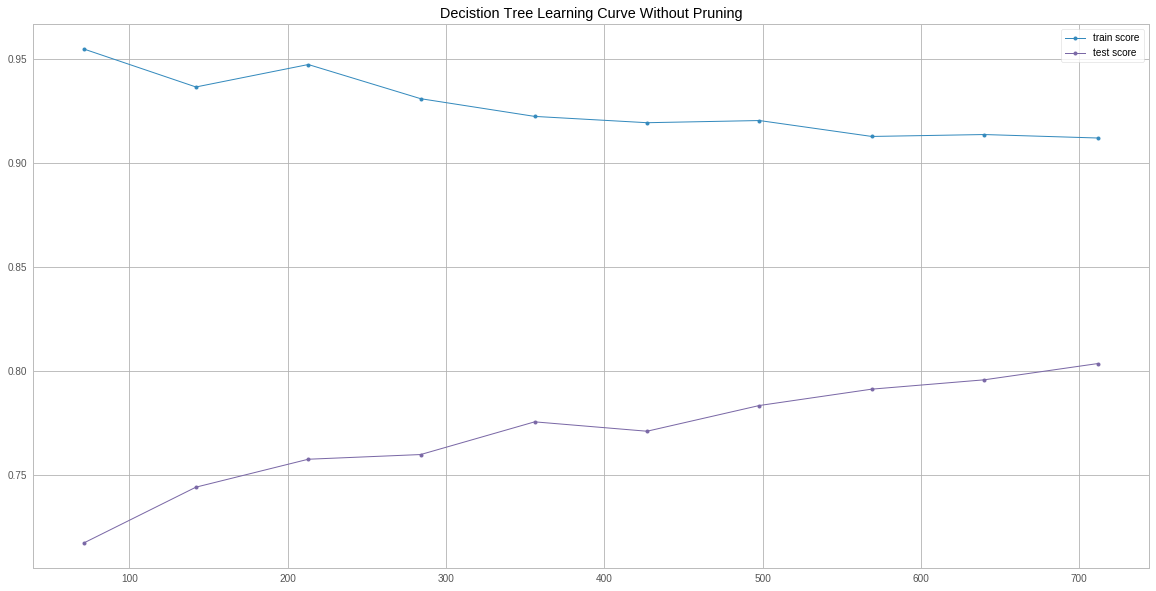

In [334]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('Decistion Tree Learning Curve Without Pruning')
plt.show()

with pruning

In [346]:
estimator = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=2, min_samples_split=4)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.8387755102040817


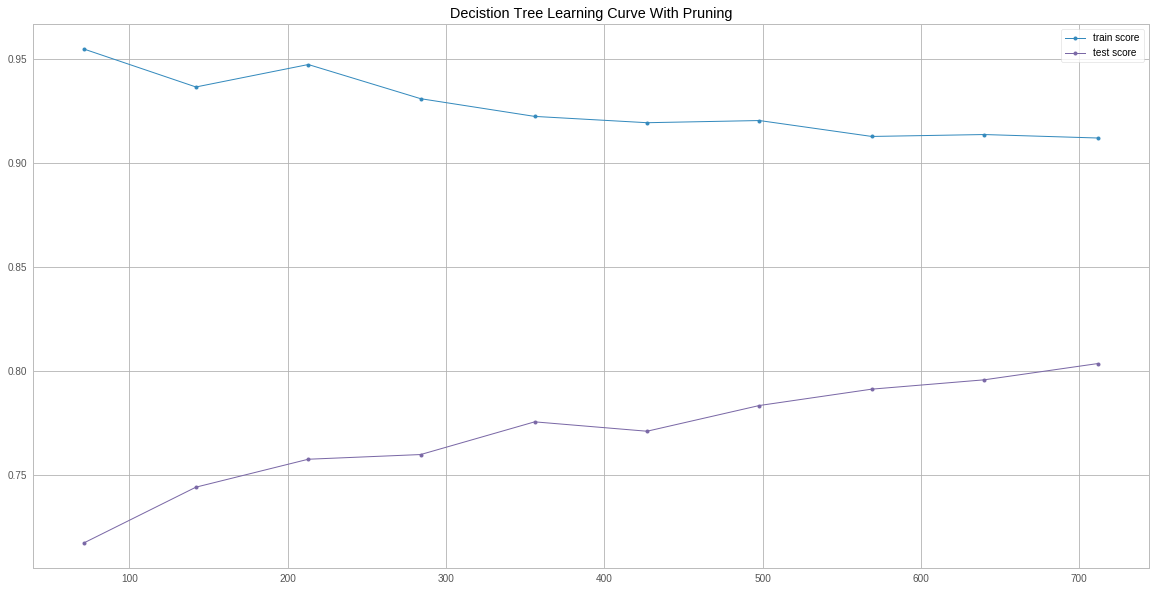

In [347]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('Decistion Tree Learning Curve With Pruning')
plt.show()

pruning for decision tree based model is also important. Compared to no pruning was used, in Fig1, the gap between train and test is large and indiates the model is suffering from overfitting 

when pruning is added, i.e. contraining the max depth of the tree as well as min sample in a tree leaf node, the gap between train and test accuracy grealy reduced. The final test accuracy also improves, compared to unpruned version: 0.83 vs 0.8

### Neural Network
reference:

    https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_feedforward_neuralnetwork/
    https://stackoverflow.com/questions/50307707/convert-pandas-dataframe-to-pytorch-tensor

In [412]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [413]:
import copy

In [414]:
train_input = torch.tensor(X_train.values.astype(np.float32))
train_target = torch.tensor(Y_train.values.astype(np.int))

In [415]:
test_input = torch.tensor(X_test.values.astype(np.float32))
test_target = torch.tensor(Y_test.values.astype(np.int))

In [416]:
train_tensor = data_utils.TensorDataset(train_input, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 1000, shuffle = True)

In [417]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.module_list = nn.ModuleList()
        dim1 = input_dim
        for i in range(num_layers):
            self.module_list.append(nn.Linear(dim1, hidden_dim))
            self.module_list.append(nn.Sigmoid())
            self.module_list.append(nn.Dropout(p=0.2))
            dim1 = hidden_dim
        self.module_list.append(nn.Linear(dim1, output_dim))

    def forward(self, x):
        out = x
        for module in self.module_list:
            out = module(out)
            
        return out

In [418]:
model = MultiLayerPerceptron(input_dim=6, hidden_dim=100, num_layers=2, output_dim=2)

In [419]:
criterion = nn.CrossEntropyLoss()

In [420]:
learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [421]:
num_epochs = 500
train_acc_list, test_acc_list, train_loss_list, model_list = [], [], [], []

In [422]:
torch.manual_seed(7)
for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y.view(-1))
        loss.backward()
        optimizer.step()
    
        model.eval()    
        # Eval on train batch
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == batch_y.view(-1)).sum()
        train_acc = 100 * correct / len(batch_x)
        
        # Eval on test set

        outputs = model(test_input)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == test_target.view(-1)).sum()
        test_acc = 100 * correct / len(test_input)

        print('epoch', epoch, 'loss', loss.data, 'train_acc', train_acc, 'test_acc', test_acc)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        train_loss_list.append(float(loss.data.numpy()))
        model_list.append(copy.deepcopy(model))

epoch 0 loss tensor(0.7007) train_acc tensor(38.3427) test_acc tensor(38.5475)
epoch 1 loss tensor(0.7018) train_acc tensor(38.3427) test_acc tensor(38.5475)
epoch 2 loss tensor(0.7001) train_acc tensor(38.3427) test_acc tensor(38.5475)
epoch 3 loss tensor(0.7041) train_acc tensor(38.7640) test_acc tensor(38.5475)
epoch 4 loss tensor(0.6989) train_acc tensor(39.1854) test_acc tensor(39.1061)
epoch 5 loss tensor(0.7010) train_acc tensor(38.2022) test_acc tensor(37.9888)
epoch 6 loss tensor(0.7032) train_acc tensor(35.3933) test_acc tensor(31.2849)
epoch 7 loss tensor(0.6968) train_acc tensor(48.5955) test_acc tensor(40.2235)
epoch 8 loss tensor(0.7012) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 9 loss tensor(0.6967) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 10 loss tensor(0.6913) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 11 loss tensor(0.7008) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 12 loss tensor(0.6933) train_acc tensor(61.6

epoch 113 loss tensor(0.6656) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 114 loss tensor(0.6710) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 115 loss tensor(0.6738) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 116 loss tensor(0.6733) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 117 loss tensor(0.6790) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 118 loss tensor(0.6687) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 119 loss tensor(0.6755) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 120 loss tensor(0.6719) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 121 loss tensor(0.6678) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 122 loss tensor(0.6743) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 123 loss tensor(0.6669) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 124 loss tensor(0.6725) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 125 loss tensor(0.6713

epoch 224 loss tensor(0.6666) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 225 loss tensor(0.6715) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 226 loss tensor(0.6669) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 227 loss tensor(0.6693) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 228 loss tensor(0.6735) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 229 loss tensor(0.6772) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 230 loss tensor(0.6733) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 231 loss tensor(0.6667) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 232 loss tensor(0.6777) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 233 loss tensor(0.6728) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 234 loss tensor(0.6633) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 235 loss tensor(0.6712) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 236 loss tensor(0.6608

epoch 333 loss tensor(0.6679) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 334 loss tensor(0.6711) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 335 loss tensor(0.6684) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 336 loss tensor(0.6692) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 337 loss tensor(0.6665) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 338 loss tensor(0.6732) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 339 loss tensor(0.6651) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 340 loss tensor(0.6644) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 341 loss tensor(0.6654) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 342 loss tensor(0.6783) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 343 loss tensor(0.6683) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 344 loss tensor(0.6747) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 345 loss tensor(0.6739

epoch 439 loss tensor(0.6744) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 440 loss tensor(0.6669) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 441 loss tensor(0.6739) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 442 loss tensor(0.6725) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 443 loss tensor(0.6671) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 444 loss tensor(0.6672) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 445 loss tensor(0.6750) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 446 loss tensor(0.6796) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 447 loss tensor(0.6711) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 448 loss tensor(0.6703) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 449 loss tensor(0.6733) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 450 loss tensor(0.6755) train_acc tensor(61.6573) test_acc tensor(61.4525)
epoch 451 loss tensor(0.6765

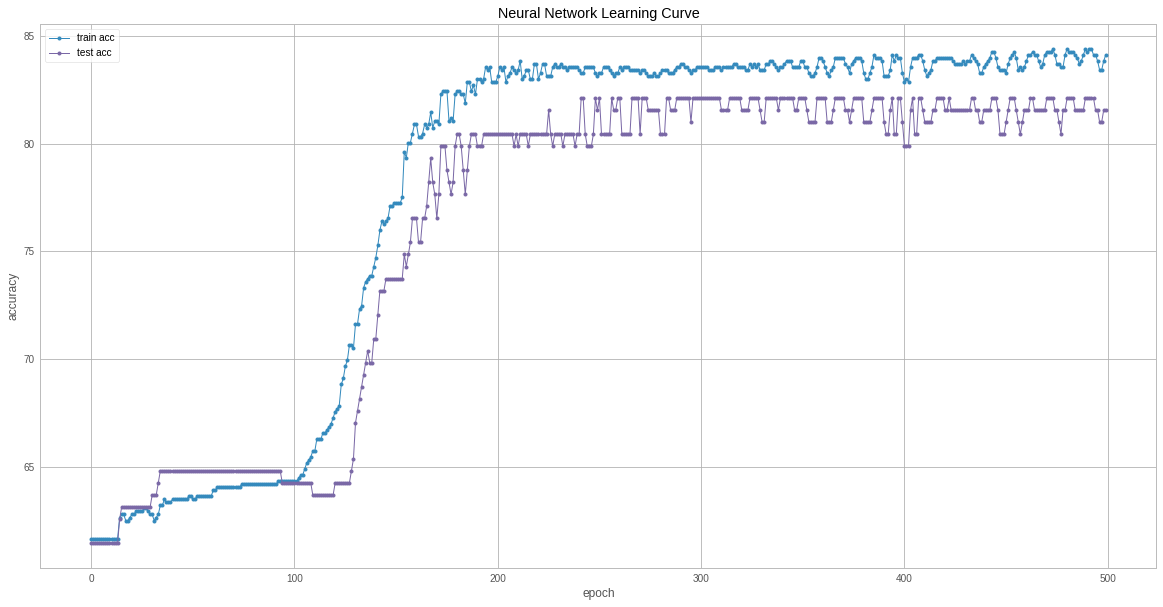

In [359]:
plt.plot(train_acc_list, '.-', label='train acc')
plt.plot(test_acc_list, '.-', label='test acc')
plt.legend(loc="best")
plt.title('Neural Network Learning Curve')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

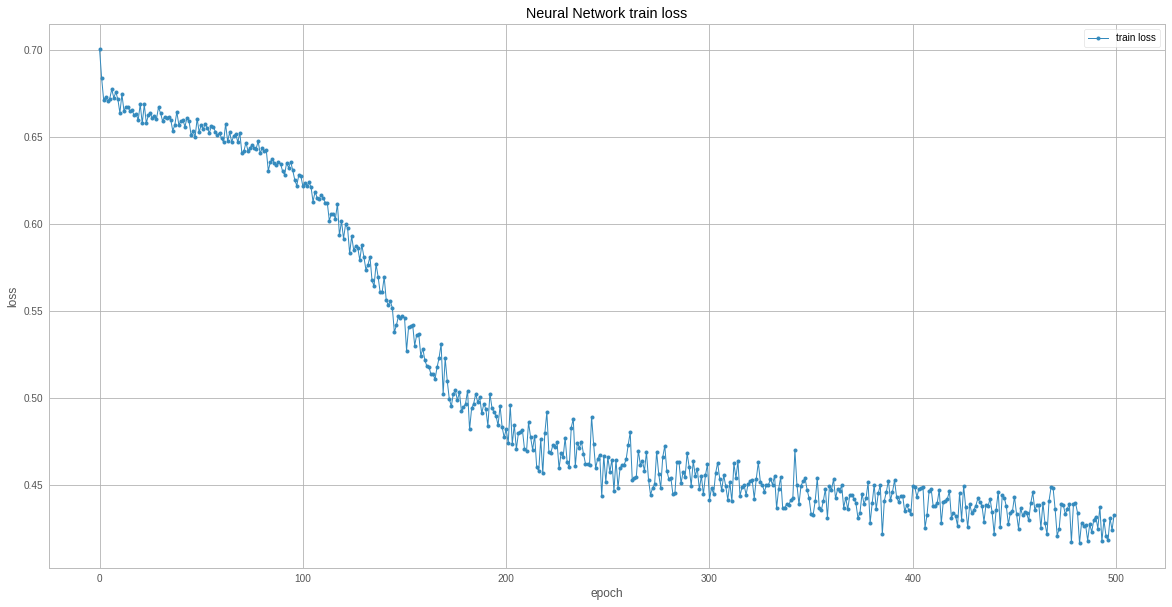

In [360]:
plt.plot(train_loss_list, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Neural Network train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

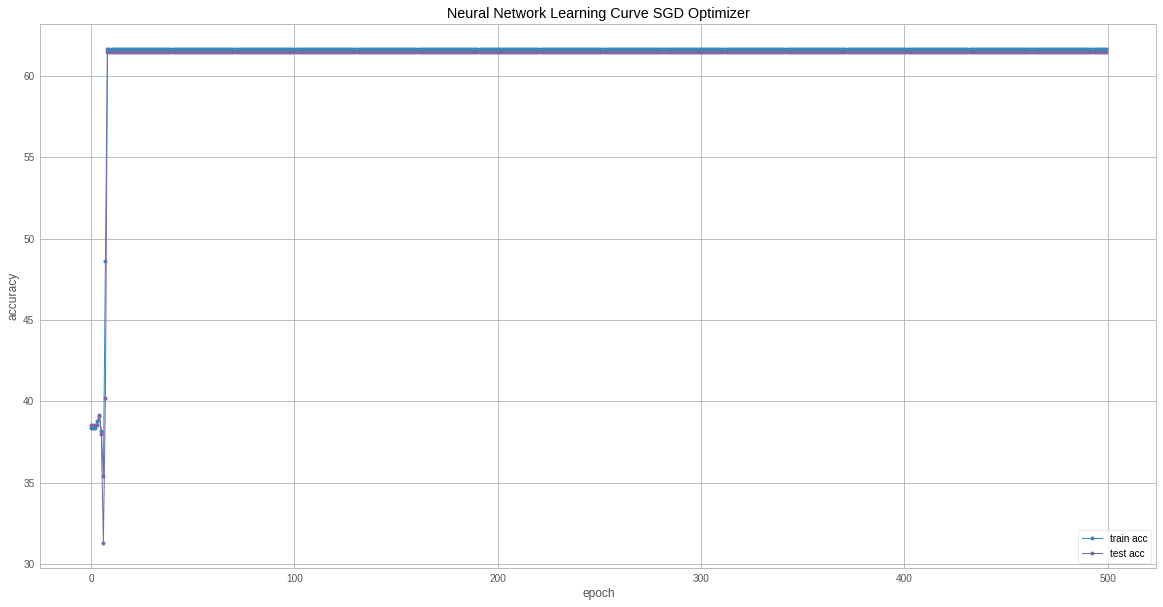

In [423]:
plt.plot(train_acc_list, '.-', label='train acc')
plt.plot(test_acc_list, '.-', label='test acc')
plt.legend(loc="best")
plt.title('Neural Network Learning Curve SGD Optimizer')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [407]:
outputs = model_list[300](test_input)
_, predicted = torch.max(outputs.data, 1)
auc = metrics.roc_auc_score(predicted, Y_test)
print(auc)

0.8337162990196079


In [362]:
sum(p.numel() for p in model.parameters())

11002

### Boosting
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

In [363]:
import sklearn.ensemble as ske

no pruning

In [368]:
estimator = ske.GradientBoostingClassifier(n_estimators= 500, random_state= 2)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.8042247386759582


In [369]:
train_loss, test_loss = [], []
for i, Y_pred in enumerate(estimator.staged_decision_function(X_train)):
    train_loss.append(estimator.loss_(Y_train.values.ravel(), Y_pred))
for i, Y_pred in enumerate(estimator.staged_decision_function(X_test)):
    test_loss.append(estimator.loss_(Y_test.values.ravel(), Y_pred))

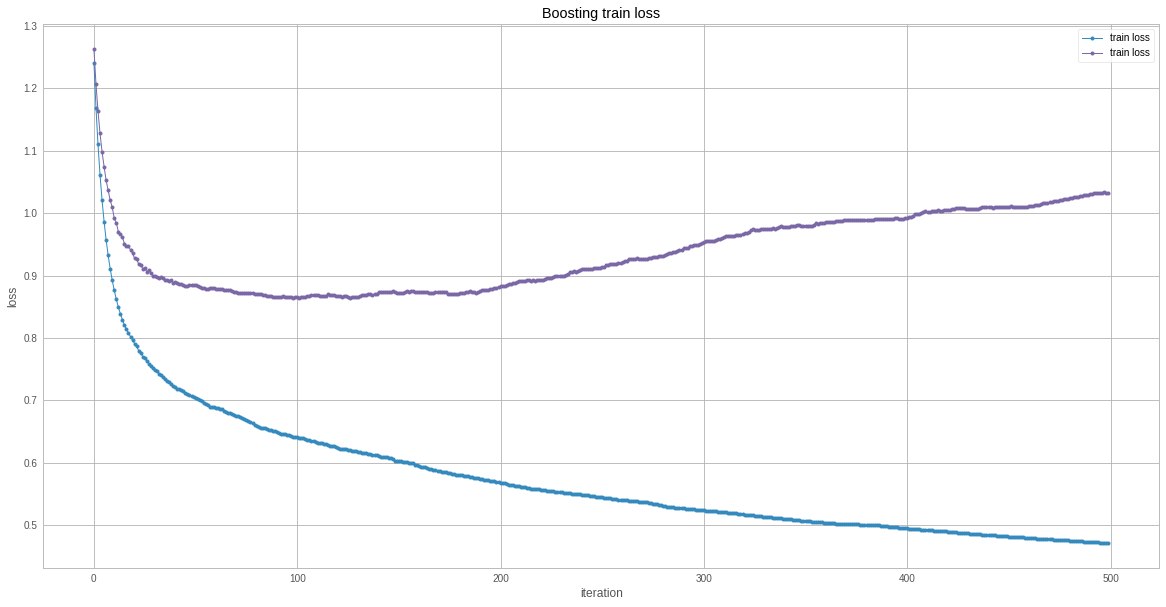

In [370]:
plt.plot(train_loss, '.-', label='train loss')
plt.plot(test_loss, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Boosting train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

with pruning

In [378]:
estimator = ske.GradientBoostingClassifier(n_estimators= 500, max_depth=2, random_state= 2)
estimator.fit(X_train, np.asarray(Y_train).ravel())
auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
print(auc)

0.8474264705882353


In [379]:
train_loss, test_loss = [], []
for i, Y_pred in enumerate(estimator.staged_decision_function(X_train)):
    train_loss.append(estimator.loss_(Y_train.values.ravel(), Y_pred))
for i, Y_pred in enumerate(estimator.staged_decision_function(X_test)):
    test_loss.append(estimator.loss_(Y_test.values.ravel(), Y_pred))

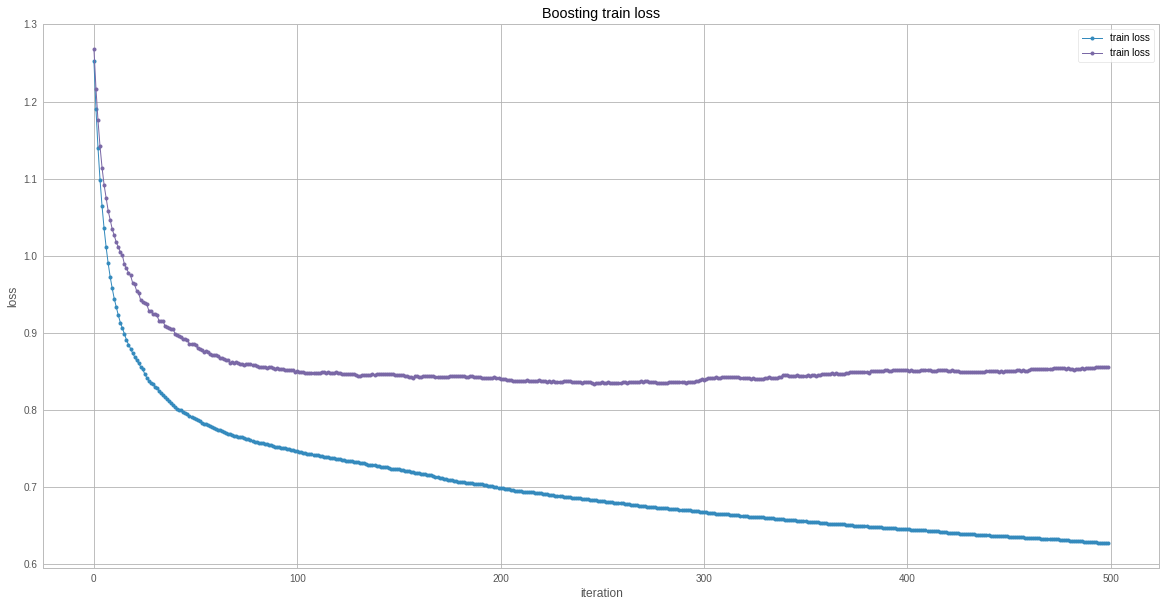

In [380]:
plt.plot(train_loss, '.-', label='train loss')
plt.plot(test_loss, '.-', label='train loss')
plt.legend(loc="best")
plt.title('Boosting train loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

### SVM
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    
default poly kernel degree is 3

In [385]:
from sklearn import svm

In [386]:
for kernel in ('poly', 'rbf'):
    for c in [0.5,1,2,4,8,16]:
        estimator = svm.SVC(C=c, kernel=kernel)
        estimator.fit(X_train, np.asarray(Y_train).ravel())
        auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
        print('C', c, 'kernel', kernel, 'auc', auc)    

C 0.5 kernel poly auc 0.8089887640449438
C 1 kernel poly auc 0.7562134502923976
C 2 kernel poly auc 0.7945887445887446
C 4 kernel poly auc 0.802675585284281
C 8 kernel poly auc 0.828670634920635
C 16 kernel poly auc 0.7963761863675582
C 0.5 kernel rbf auc 0.8179190751445087
C 1 kernel rbf auc 0.8179190751445087
C 2 kernel rbf auc 0.7316955684007707
C 4 kernel rbf auc 0.8307795698924731
C 8 kernel rbf auc 0.8024857741838874
C 16 kernel rbf auc 0.7991935483870968


In [387]:
estimator = svm.SVC(C=4, kernel='rbf')

In [388]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

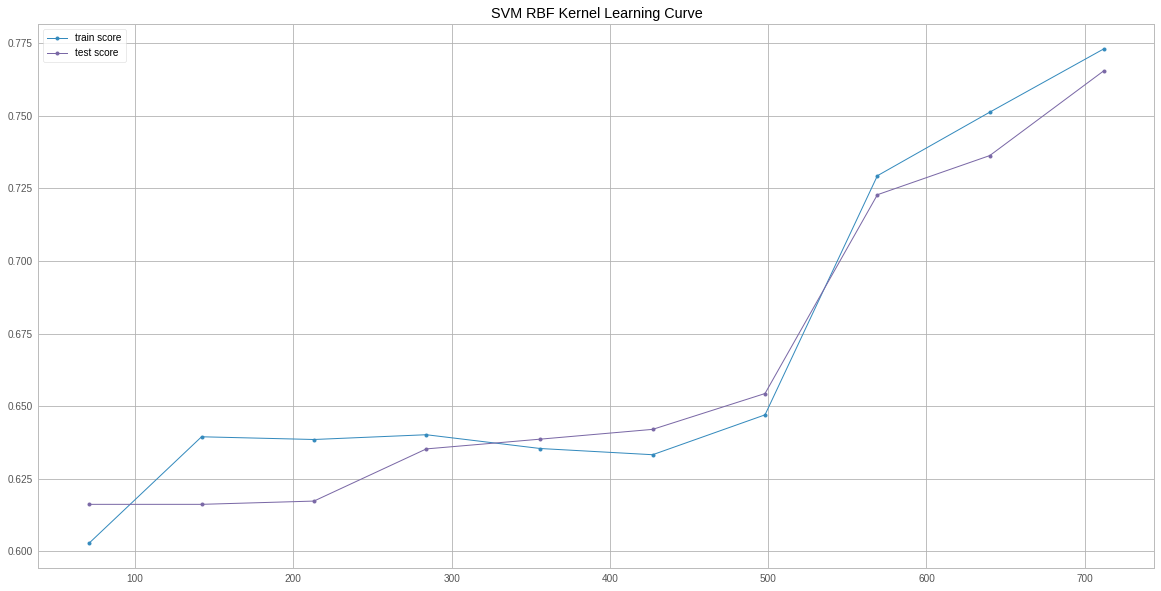

In [389]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('SVM RBF Kernel Learning Curve')
plt.show()

In [409]:
estimator = svm.SVC(C=8, kernel='poly')

In [410]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

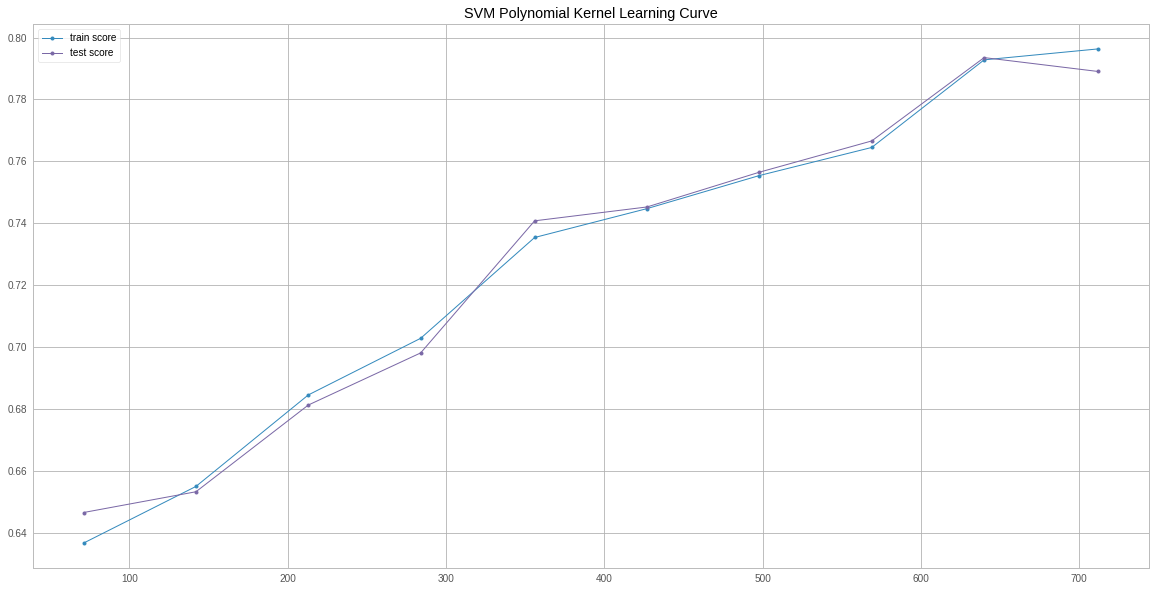

In [411]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('SVM Polynomial Kernel Learning Curve')
plt.show()

### KNN
reference:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [393]:
from sklearn.neighbors import KNeighborsClassifier

In [394]:
k_list, auc_list = [], []
for k in [1,2,4,8,16,32,64]:
    estimator = KNeighborsClassifier(n_neighbors=k)
    estimator.fit(X_train, Y_train)
    auc = metrics.roc_auc_score(estimator.predict(X_test), Y_test)
    print('k', k, 'auc', auc)
    k_list.append(k)
    auc_list.append(auc)

k 1 auc 0.8042247386759582
k 2 auc 0.8066937119675456
k 4 auc 0.7455322455322455
k 8 auc 0.7838314653383147
k 16 auc 0.7617216117216117
k 32 auc 0.7043650793650794
k 64 auc 0.6102175969725638


In [395]:
estimator = KNeighborsClassifier(n_neighbors=2)

In [396]:
train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, train_sizes=np.linspace(.1, 1.0, 10), return_times=False)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

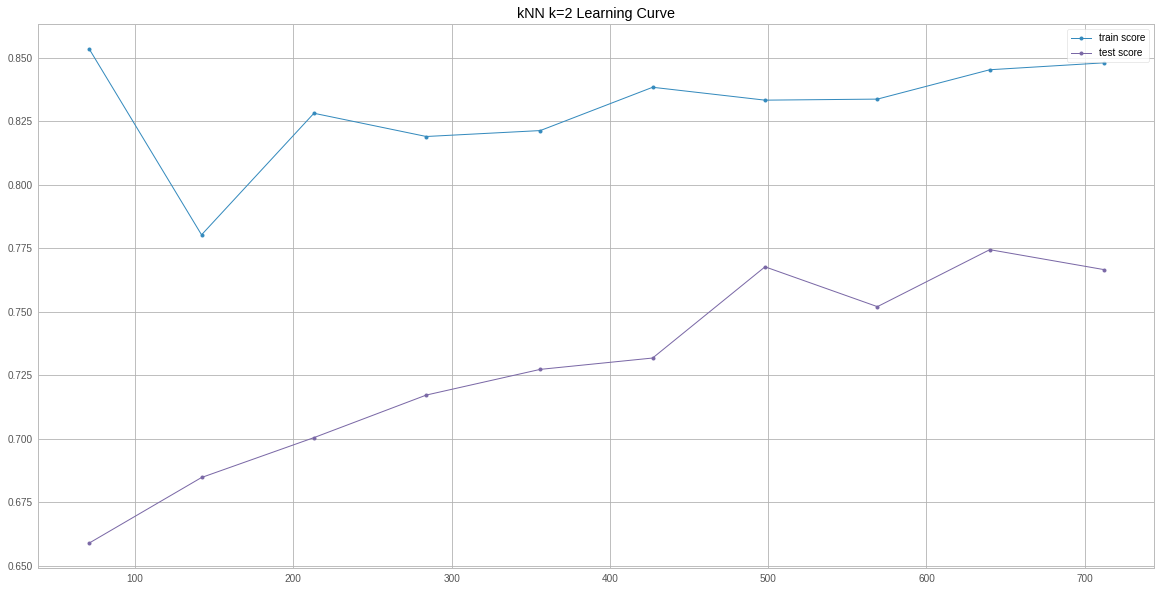

In [397]:
plt.plot(train_sizes, train_scores_mean, '.-', label='train score')
plt.plot(train_sizes, test_scores_mean, '.-', label='test score')
plt.legend(loc="best")
plt.title('kNN k=2 Learning Curve')
plt.show()